## Exercise VAEs

You need to install `torch` and `torchvision` to run the code in this notebook. You can do this via conda or pip:

```bash
pip install torch torchvision
```
or
```bash
conda install pytorch torchvision -c pytorch
```

Import the necessary libraries and download the MNIST dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Configuration
BATCH_SIZE = 100
LEARNING_RATE = 1e-3
EPOCHS = 15
LATENT_DIM = 2  # We use 2 dimensions to easily visualize the latent space later
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

# Data Loading (MNIST)
transform = transforms.ToTensor() # Normalizes to [0, 1]
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Using device: cpu
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:02<00:00, 4059208.78it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 281531.52it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:01<00:00, 1173619.38it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 585251.72it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



Define the VAE model, the training loop, and visualize the results.

In [2]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=2):
        super(VAE, self).__init__()
        
        # --- Encoder ---
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # We output two vectors: mean (mu) and log-variance (log_var)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # --- Decoder ---
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)
    
    def reparameterize(self, mu, logvar):
        """
        THE REPARAMETERIZATION TRICK
        z = mu + sigma * epsilon
        """
        if self.training:
            std = torch.exp(0.5 * logvar) # convert log_var to standard deviation
            eps = torch.randn_like(std)   # sample epsilon from standard normal
            return mu + eps * std
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3)) # Sigmoid because pixels are [0, 1]

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

model = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc_mu): Linear(in_features=400, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=400, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)


In [3]:
def loss_function(recon_x, x, mu, logvar):
    # 1. Reconstruction Loss (Binary Cross Entropy)
    # reduction='sum' sums over the batch. We want the total loss.
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # 2. KL Divergence
    # Analytical solution for KL(q(z|x) || N(0,1))
    # Formula: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [4]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)}] Loss: {loss.item()/len(data):.4f}')

    print(f'====> Epoch {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

# Run training
for epoch in range(1, EPOCHS + 1):
    train(epoch)

Epoch 1 [0/60000] Loss: 547.3298
Epoch 1 [10000/60000] Loss: 190.9673
Epoch 1 [20000/60000] Loss: 180.3047
Epoch 1 [30000/60000] Loss: 178.2884
Epoch 1 [40000/60000] Loss: 171.0500
Epoch 1 [50000/60000] Loss: 165.8799
====> Epoch 1 Average loss: 187.1644
Epoch 2 [0/60000] Loss: 174.9302
Epoch 2 [10000/60000] Loss: 172.4872
Epoch 2 [20000/60000] Loss: 166.3768
Epoch 2 [30000/60000] Loss: 166.6401
Epoch 2 [40000/60000] Loss: 169.1949
Epoch 2 [50000/60000] Loss: 166.2134
====> Epoch 2 Average loss: 165.9214
Epoch 3 [0/60000] Loss: 163.6759
Epoch 3 [10000/60000] Loss: 168.6660
Epoch 3 [20000/60000] Loss: 162.6899
Epoch 3 [30000/60000] Loss: 160.5107
Epoch 3 [40000/60000] Loss: 170.1316
Epoch 3 [50000/60000] Loss: 155.7185
====> Epoch 3 Average loss: 162.2544
Epoch 4 [0/60000] Loss: 153.4862
Epoch 4 [10000/60000] Loss: 153.5757
Epoch 4 [20000/60000] Loss: 164.3146
Epoch 4 [30000/60000] Loss: 160.9782
Epoch 4 [40000/60000] Loss: 160.9804
Epoch 4 [50000/60000] Loss: 156.6042
====> Epoch 4 Ave

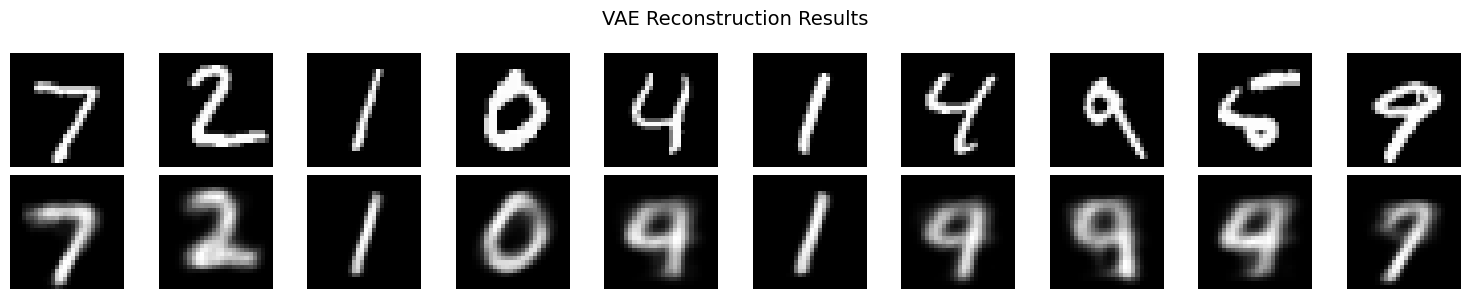

In [5]:
def visualize_reconstruction():
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(DEVICE)
        recon, _, _ = model(data)
        
        # Visualize original and reconstructed images
        n = 10  # Number of images to display
        fig, axes = plt.subplots(2, n, figsize=(15, 3))
        
        for i in range(n):
            # Original images
            axes[0, i].imshow(data[i].cpu().squeeze(), cmap='gray')
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_ylabel('Original', fontsize=12)
            
            # Reconstructed images
            axes[1, i].imshow(recon[i].cpu().view(28, 28), cmap='gray')
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_ylabel('Reconstructed', fontsize=12)
        
        plt.suptitle('VAE Reconstruction Results', fontsize=14)
        plt.tight_layout()
        plt.show()

visualize_reconstruction()

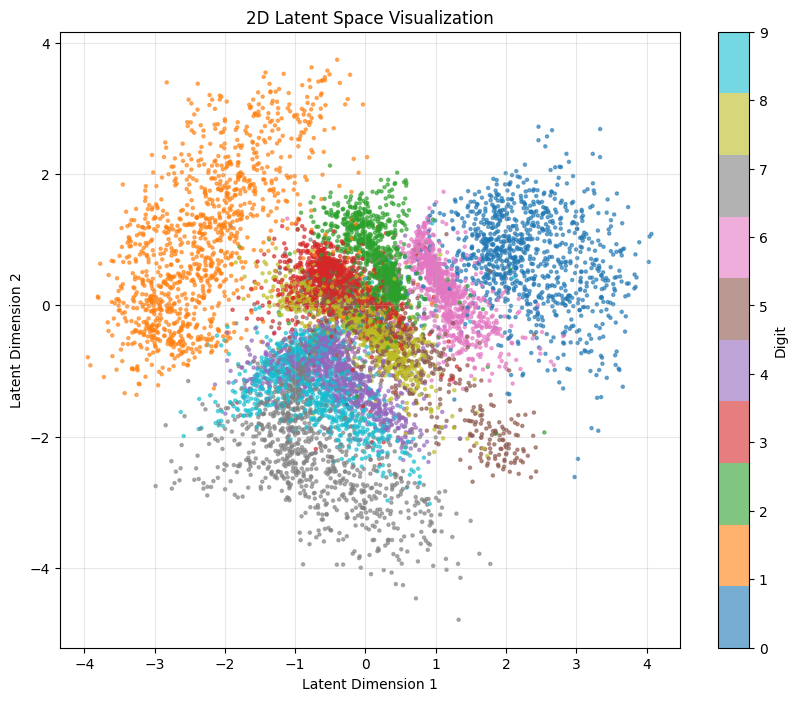

In [6]:
def visualize_latent_space():
    """Visualize the 2D latent space with color-coded digits"""
    model.eval()
    latents = []
    labels_list = []
    
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(DEVICE)
            mu, _ = model.encode(data.view(-1, 784))
            latents.append(mu.cpu().numpy())
            labels_list.append(labels.numpy())
    
    latents = np.concatenate(latents, axis=0)
    labels_list = np.concatenate(labels_list, axis=0)
    
    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels_list, 
                         cmap='tab10', alpha=0.6, s=5)
    plt.colorbar(scatter, label='Digit')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('2D Latent Space Visualization')
    plt.grid(True, alpha=0.3)
    plt.show()

visualize_latent_space()

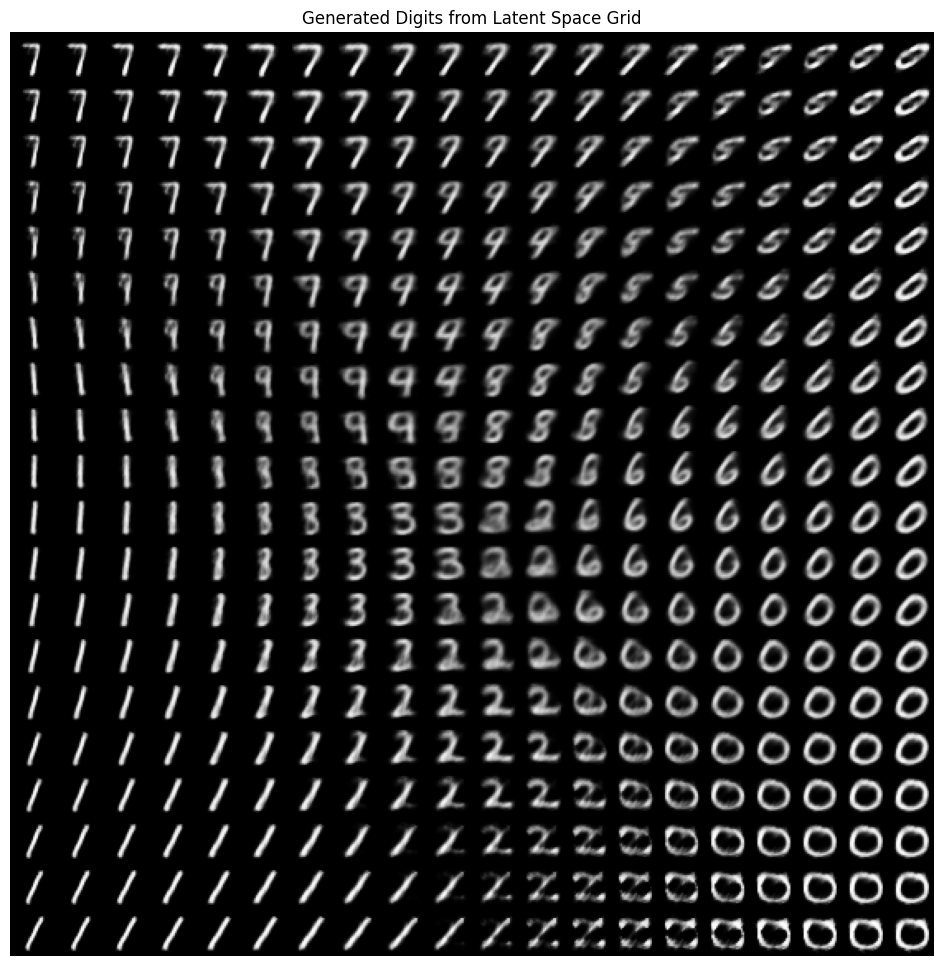

In [7]:
def generate_from_latent():
    """Generate images by sampling from the latent space"""
    model.eval()
    
    # Create a grid of points in latent space
    n = 20  # Grid size
    digit_size = 28
    
    # Generate a 2D grid in latent space
    grid_x = np.linspace(-3, 3, n)
    grid_y = np.linspace(-3, 3, n)
    
    figure = np.zeros((digit_size * n, digit_size * n))
    
    with torch.no_grad():
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(DEVICE)
                x_decoded = model.decode(z_sample)
                digit = x_decoded.cpu().view(digit_size, digit_size).numpy()
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit
    
    plt.figure(figsize=(12, 12))
    plt.imshow(figure, cmap='gray')
    plt.title('Generated Digits from Latent Space Grid')
    plt.axis('off')
    plt.show()

generate_from_latent()